In [72]:
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, Bidirectional, InputLayer, Dropout
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

In [73]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32
embedding_size = 128
epochs_qty = 5
dropout_rate = 0.5

loss_f =  'binary_crossentropy' #'mean_squared_error'
optimizer = 'adam'
metrics = 'accuracy'

In [74]:
# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів. додавання 0 в початок
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)

In [76]:
def show_histories(histories):
    num_configs = len(histories)
    columns = 3
    rows = (num_configs // columns) + (num_configs % columns > 0)
    
    fig, axes = plt.subplots(rows, columns, figsize=(18, rows * 4))
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    for idx, (key, history) in enumerate(histories.items()):
        ax = axes[idx]
        
        # Plot training & validation accuracy values
        ax.plot(history['accuracy'])
        ax.plot(history['val_accuracy'])
        ax.set_title(f'Model accuracy - {key}')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper left')
    
    # Remove any empty subplots
    for i in range(len(histories), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(rows, columns, figsize=(18, rows * 4))
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    for idx, (key, history) in enumerate(histories.items()):
        ax = axes[idx]
        
        # Plot training & validation accuracy values
        ax.plot(history['loss'])
        ax.plot(history['val_loss'])
        ax.set_title(f'Model loss - {key}')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper left')
    
    # Remove any empty subplots
    for i in range(len(histories), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

In [77]:
def make_predictions(model, input_data, threshold=0.5):
    probabilities = model.predict(input_data)
    binary_predictions = (probabilities > threshold).astype(int)
    return binary_predictions

# Function to visualize predictions
def show_predictions(model, input_test, y_test):
    predictions = make_predictions(model, input_test)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test)), y_test, color='blue', label='True Values')
    plt.plot(range(len(predictions)), predictions, color='red', linestyle='--', label='Predictions')
    plt.title('True vs Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [78]:
# from tqdm.keras import TqdmCallback

histories = {}
best_val_accuracy = 0
val_accuracy = 0

for bdr in [False]:               #True,                      #  2
    for DeepRNN in [False]:       #True,                      # *2
        for model_type in [LSTM]: #SimpleRNN, GRU,            # *3   
            for units in [2,4,8]: #8                          # *3

                model = Sequential()
                model.add(InputLayer(input_shape=(maxlen,)))
                model.add(Embedding(max_features, embedding_size))

                if DeepRNN:
                    if bdr:
                        model.add(Bidirectional(model_type(units, return_sequences=True)))
                        model.add(Dropout(dropout_rate))
                        model.add(Bidirectional(model_type(units)))
                        model.add(Dropout(dropout_rate))
                    else:
                        model.add(model_type(units))
                        model.add(Dropout(dropout_rate))
                        model.add(model_type(units))
                        model.add(Dropout(dropout_rate))
                else:
                    if bdr:
                        model.add(Bidirectional(model_type(units)))
                    else:
                        model.add(model_type(units))

                model.add(Dense(1, activation='sigmoid'))
                model.compile(loss = loss_f, optimizer = optimizer, metrics=[metrics])
                message = f'{model_type.__name__}, Bidiractional= {bdr} units= {units}' #, DeepRNN= {bool(deepRnn-1)}'
                print(message) 
                model.summary()

                # Early stopping callback
                early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                # Train the model
                print('Training the model...')
                history = model.fit(input_train,y_train, epochs=epochs_qty, batch_size=batch_size,validation_data=(input_test, y_test), callbacks=[early_stopping])  #,callbacks=[TqdmCallback(verbose=0)]

                histories[message] = history.history

                val_accuracy = max(history.history['val_accuracy'])
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_model = model

LSTM, Bidiractional= False units= 2


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 2)              │         1,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281,051 (4.89 MB)

 Trainable params: 1,281,051 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 212s 261ms/step - accuracy: 0.6965 - loss: 0.5878 - val_accuracy: 0.8255 - val_loss: 0.4292
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 205s 262ms/step - accuracy: 0.8493 - loss: 0.3859 - val_accuracy: 0.8210 - val_loss: 0.4325
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 201s 257ms/step - accuracy: 0.8894 - loss: 0.3025 - val_accuracy: 0.8336 - val_loss: 0.4106
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 168s 215ms/step - accuracy: 0.9030 - loss: 0.2665 - val_accuracy: 0.8306 - val_loss: 0.4161
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 161s 206ms/step - accuracy: 0.9303 - loss: 0.2142 - val_accuracy: 0.8369 - val_loss: 0.4214
LSTM, Bidiractional= False units= 4


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 4)              │         2,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282,133 (4.89 MB)

 Trainable params: 1,282,133 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 220s 272ms/step - accuracy: 0.6973 - loss: 0.5808 - val_accuracy: 0.8002 - val_loss: 0.4468
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 218s 279ms/step - accuracy: 0.8365 - loss: 0.3865 - val_accuracy: 0.8360 - val_loss: 0.3932
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 214s 274ms/step - accuracy: 0.8623 - loss: 0.3345 - val_accuracy: 0.8270 - val_loss: 0.4099
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 244s 251ms/step - accuracy: 0.9003 - loss: 0.2611 - val_accuracy: 0.7960 - val_loss: 0.4437
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 198s 253ms/step - accuracy: 0.8960 - loss: 0.2705 - val_accuracy: 0.8371 - val_loss: 0.4070
LSTM, Bidiractional= False units= 8


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 8)              │         4,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,393 (4.90 MB)

 Trainable params: 1,284,393 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 195s 242ms/step - accuracy: 0.7091 - loss: 0.5495 - val_accuracy: 0.7944 - val_loss: 0.4755
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 184ms/step - accuracy: 0.8787 - loss: 0.3013 - val_accuracy: 0.8734 - val_loss: 0.3125
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 186ms/step - accuracy: 0.9090 - loss: 0.2357 - val_accuracy: 0.8632 - val_loss: 0.3462
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 28078s 36s/step - accuracy: 0.9369 - loss: 0.1747 - val_accuracy: 0.8775 - val_loss: 0.3284
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 196s 250ms/step - accuracy: 0.9585 - loss: 0.1226 - val_accuracy: 0.8690 - val_loss: 0.3902


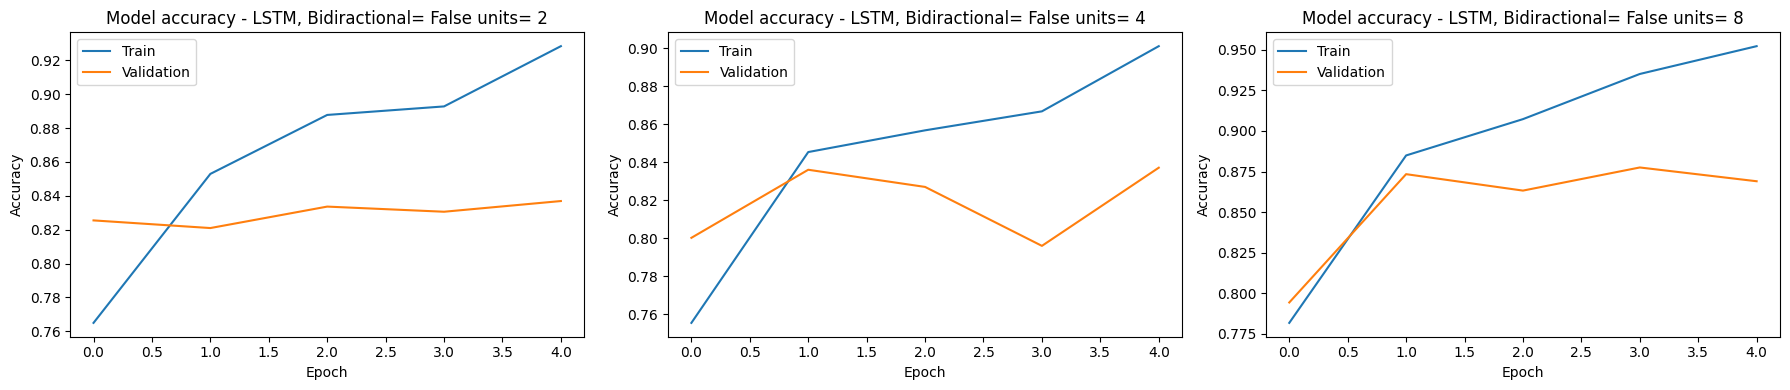

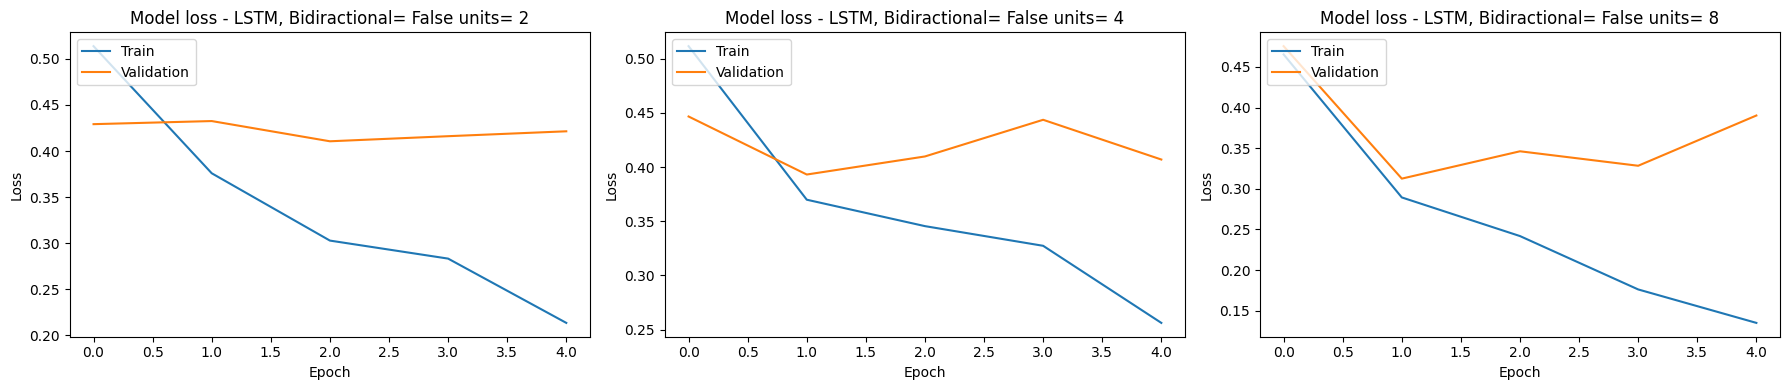

782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step


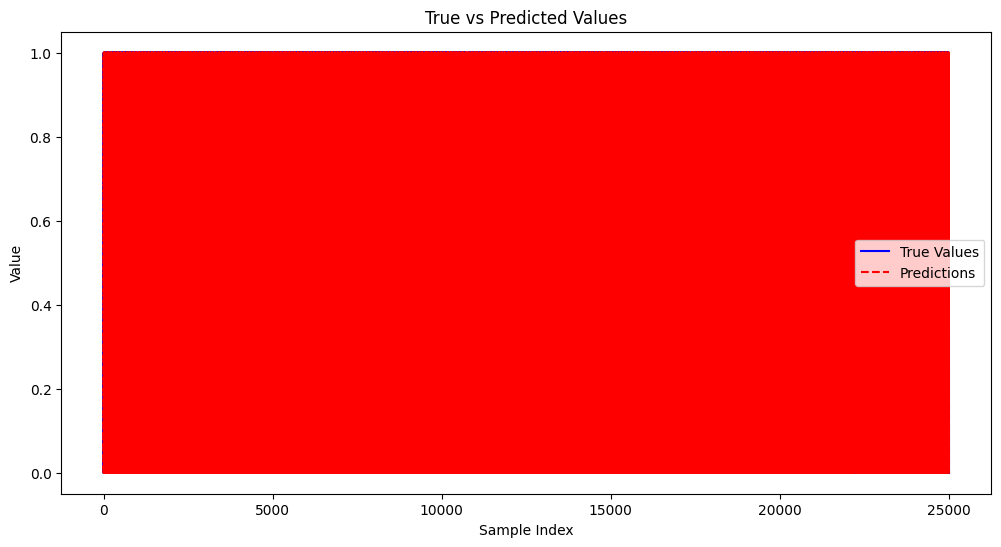

In [79]:
show_histories(histories)
show_predictions(best_model, input_test, y_test)

додаю ще результати експериментів з Колаб.

Висновки. Bidirectional та Deep суттєво довше рахуються. приріст не значний.

оптимальним як на мене є GRU з 4 комірками. з візуалізацією Pridiction щось не вийшло


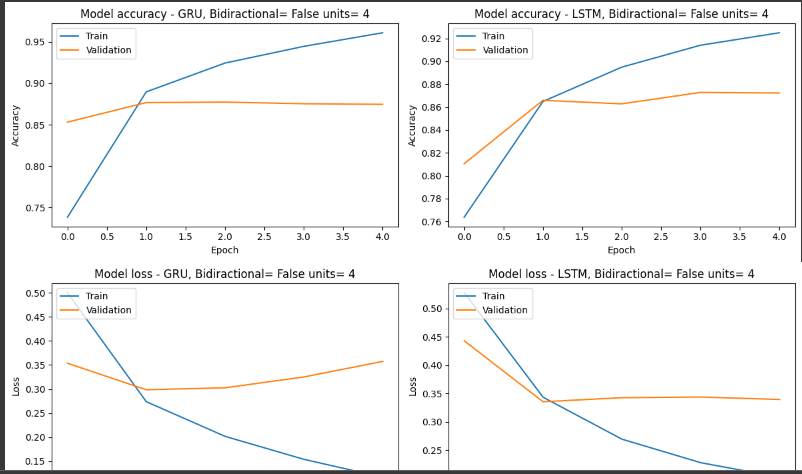![Simple-Bi-8 - 78%.PNG](<attachment:Simple-Bi-8 - 78%.PNG>) ![Simple-Bi-4 - 76%.PNG](<attachment:Simple-Bi-4 - 76%.PNG>) ![Simple-Bi-2 - 76%.PNG](<attachment:Simple-Bi-2 - 76%.PNG>) ![GRU-BI-8- 88%.PNG](<attachment:GRU-BI-8- 88%.PNG>) ![GRU-BI-4- 87%.PNG](<attachment:GRU-BI-4- 87%.PNG>) ![GRU-BI-2- 86%.PNG](<attachment:GRU-BI-2- 86%.PNG>)
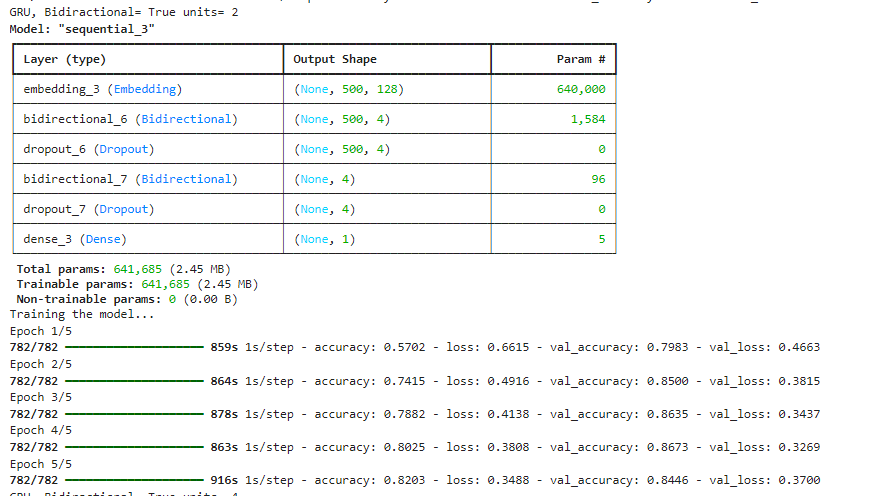
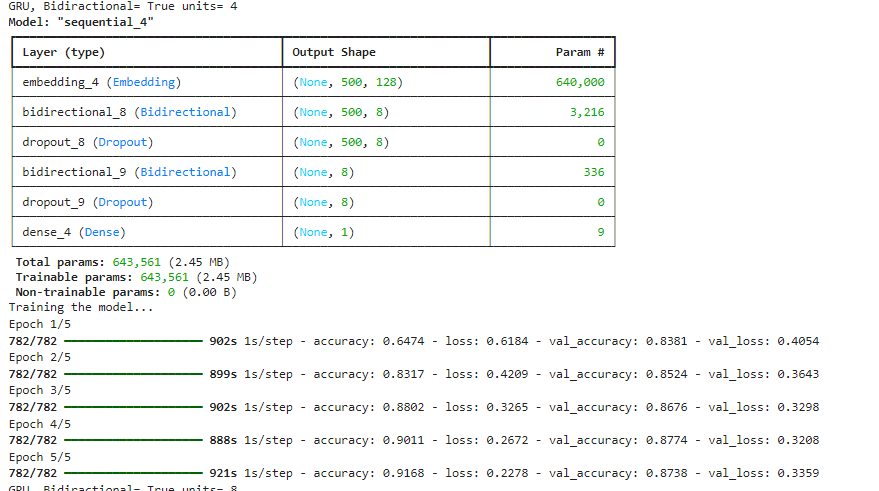
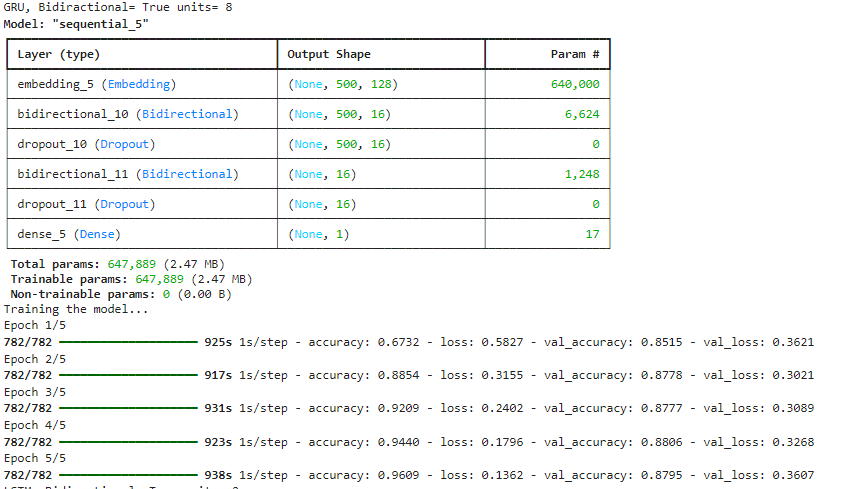
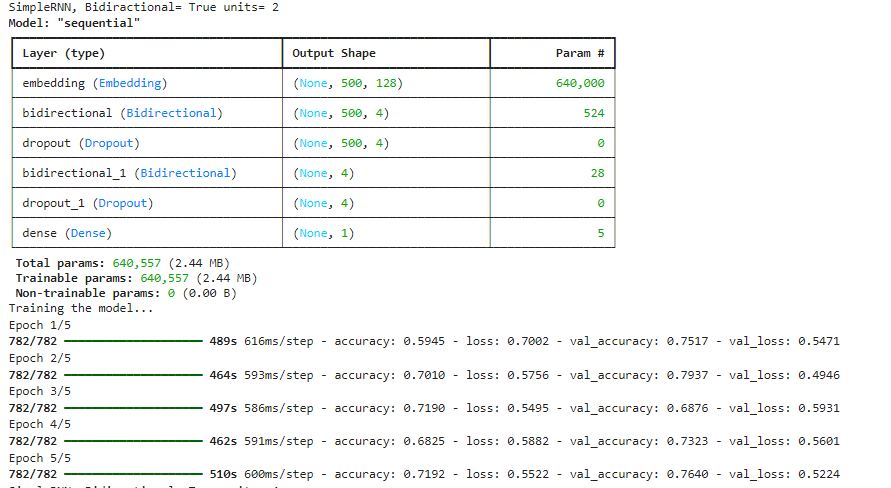
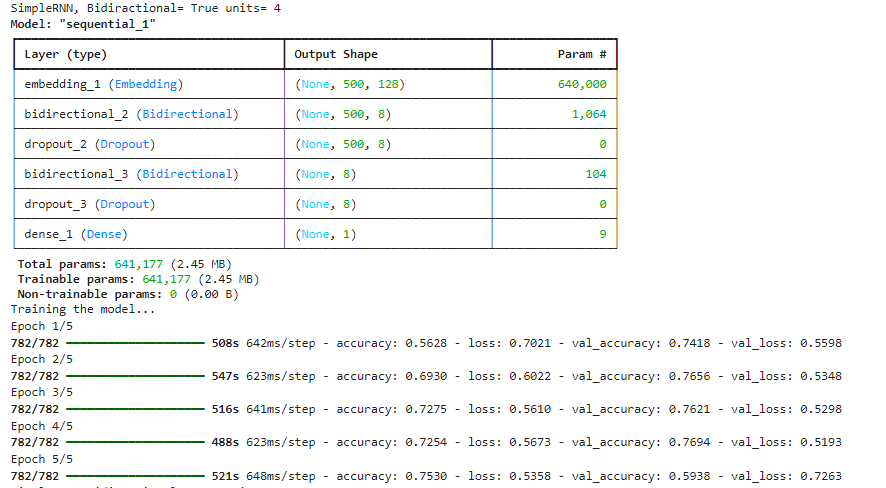
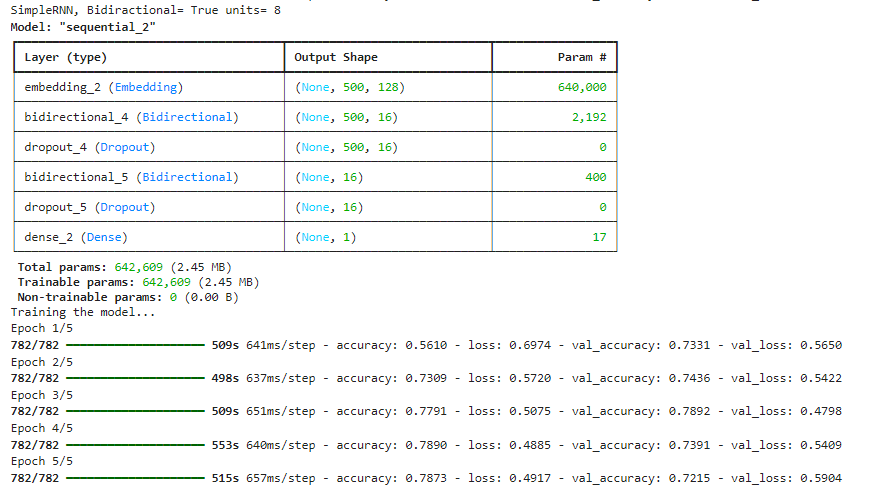